# Lens Calculator for Fabry-Perot Cavity

Calulate the change in a beam of light starting at the beam waist in a Fabry-Perot cavity then going through a series of lenses

In [1]:
import numpy as np
import sympy as sym
import matplotlib as mp
import matplotlib.pyplot as plt
from sympy.physics.mechanics import init_vprinting

# plt.style.use('dark_background')
%matplotlib inline
%config InlineBackend.figure_format = 'pdf'
init_vprinting()

## Important Functions

In [2]:
# Functions for lenses and distance
# =================================
def as_sym(x, use_sym=False):
    if use_sym == False:
        M = np.array(x)
    elif use_sym == True:
        M = sym.Matrix(x)
    else:
        M = print('Error: Please specify True or False for Sympy')
    return M

# Curved interface matrix
def interface(ni, nf, R, use_sym=False):
    A = [[1, 0], [(ni-nf)/(R*nf), ni/nf]]
    M = as_sym(A, use_sym)
    return M

# Distance matrix
def dist(d, use_sym=False):
    A = [[1, d], [0, 1]]
    M = as_sym(A, use_sym)
    return M

# Lens matrix
# Use sym.oo for flat interface
def lens(n_medium=1, n_lens=1, R_in=sym.oo, R_out=sym.oo, thickness=5, use_sym=False):
    interface_in = interface(n_medium, n_lens, R_in, use_sym)
    interface_out = interface(n_lens, n_medium, R_out, use_sym)
    lens_thickness = as_sym([[1, thickness], [0, 1]], use_sym)
    return interface_out@lens_thickness@interface_in

# Functions for the beam:
# =======================

# Waist (radius) of beam and 
# angle with respect to x-axis
def beam(waist, angle, use_sym=False):
    return as_sym([[waist], [angle]], use_sym)

# Rayleigh length
def z_Rayleigh(beam_front_curvature, dist, use_sym=False):
    if use_sym == False:
        z_R = np.sqrt(dist * (beam_front_curvature-dist))
    elif use_sym == True:
        z_R = sym.sqrt(dist * (beam_front_curvature-dist))
    else: 
        z_R = print('Error: Please specify True or False for Sympy')
    return z_R

# Beam waist size
def waist0(wavelength, z_R, use_sym=False):
    if use_sym == False:
        w_0 = np.sqrt((wavelength/sym.pi) * z_R)
    elif use_sym == True:
        w_0 = sym.sqrt((wavelength/np.pi) * z_R)
    else: 
        w_0 = print('Error: Please specify True or False for Sympy')
    return w_0

# Beam waist after certain distance z
def waistz(wavelength, z_R, z, use_sym=False):
    w_0 = waist0(wavelength, z_R, use_sym)
    if use_sym == False:
        w_z =  w_0 * np.sqrt(1 + (z/z_R)**2)
    elif use_sym == True:
        w_z =  w_0 * sym.sqrt(1 + (z/z_R)**2)
    else: 
        w_z = print('Error: Please specify True or False for Sympy') 
    return w_z

# Complex beam parameter
def q_CBP(dist, z_R):
    return dist + z_R*1j

# The angle the beam makes with the 
# mirror of the Fabry-Perot cavity
def Theta0(wavelength, mirror_curvature, mirror_focal, lens_pos, use_sym=False):
    # We want the radius of curvature of the beam front to match
    # the radius of curvature of the mirror when it hits the 
    # mirror after originating from the focal length of the mirror
    z_r = z_Rayleigh(mirror_curvature, mirror_focal, use_sym)
    w_z = waistz(wavelength, z_r, mirror_focal, use_sym)
    theta = w_z/lens_pos
    return theta

## Symbols

In [3]:
# Beam waists
# w0, wf = sym.symbols('w_0 w_f', real=True)

# Beam angle (small angles)
# theta0, thetaf = sym.symbols('theta_0 theta_f', real=True)

# Complex beam parameters
# q0, qf = sym.symbols('q_0 q_f')

# Distances
# For lens thickness
d0, d1, d2, d3, d4 = sym.symbols('d:5', real=True)
# For distance between lens
x0, x1, x2, x3, x4 = sym.symbols('x:5', real=True)

# Indicies of refraction
nl, nm = sym.symbols('n_l n_m', real=True)

# Radius of curvature for lens
r00, r01, r10, r11, r20, r21, r30, r31 = sym.symbols('r_{00} r_{01} r_{10} r_{11} r_{20} r_{21} r_{30} r_{31}')

## Matricies for beam, lenses, and distances

In [4]:
dist0 = dist(x0, use_sym=True)
lens0 = lens(nm, nl, r00, r01, d0, use_sym=True)
dist1 = dist(x1, use_sym=True)
lens1 = lens(nm, nl, r10, r11, d1, use_sym=True)
dist2 = dist(x2, use_sym=True)
lens2 = lens(nm, nl, r20, r21, d2, use_sym=True)
dist3 = dist(x3, use_sym=True)
lens3 = lens(nm, nl, r30, r31, d3, use_sym=True)

## Now calculate

In [19]:
wavelength=780e-6
R = -50
A0 = (R/x0 + 1)/(R**2)
q0_Num = 1/R + 1j*sym.sqrt(A0)
q0_Den = (1/R)**2 + A0
q0 = q0_Num/q0_Den

Rf = -10e6
wf = 1
Af = wavelength/(sym.pi * wf**2)
qf_Num = (1/Rf) + 1j*Af
qf_Den = (1/Rf)**2 + Af**2
qf = qf_Num/qf_Den

beam0 = beam(q0, 1, use_sym=True)
beamf = beam(qf, 1, use_sym=True)

In [20]:
T = lens2 @ dist2 @ lens1 @ dist1 @ lens0
# T = lens1 @ dist1 @ lens0  
T_sub = T.subs({nm:1, nl:1.515, 
                r00:-50.0, r01:sym.oo, d0:6,
                # Lens 1
#                 r10: 13.1, r11:sym.oo, d1:11.7, # 25f Plano-Convex
                r10: 25.8, r11:sym.oo, d1:5.3, # 50f Plano-Convex
#                 r10: 38.6, r11:sym.oo, d1:4.1, # 75f Plano-Convex
#                 r10: 51.5, r11:sym.oo, d1:3.6, # 100f Plano-Convex
#                 r10:103.0, r11:sym.oo, d1:2.8, # 200f Plano-Convex
                # Lens 2
#                 r20: sym.oo, r21:sym.oo, d2:0,
#                 r20: 13.1, r21:sym.oo, d2:11.7, # 25f Plano-Convex
#                 r20: 25.8, r21:sym.oo, d2:5.3, # 50f Plano-Convex
#                 r20: 38.6, r21:sym.oo, d2:4.1, # 75f Plano-Convex
                r20: 51.5, r21:sym.oo, d2:3.6, # 100f Plano-Convex
#                 r20:103.0, r21:sym.oo, d2:2.8, # 200f Plano-Convex
#                 r30:400, r31:sym.oo, d3:2.8
                }).applyfunc(sym.simplify)

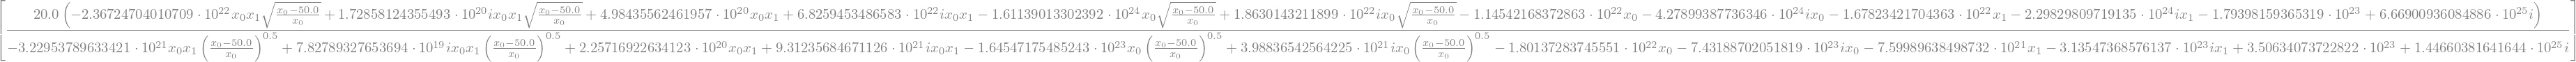

In [21]:
Tf = T_sub @ beam0
Tf2 = (Tf[0]/Tf[1] - beamf[0])
solution = sym.solvers.solve(Tf2, (x2), simplify=True)
# solution = Tf2
display(solution)

In [25]:
# Test = sym.utilities.lambdify((x0, x1), solution[0], 'numpy')
Test = sym.utilities.lambdify((x0, x1), solution[0], 'numpy')

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

X0min, X0max = 51, 55

# 2 Lens System
# -------------
for X0 in range(X0min, X0max):
    X1 = np.arange(300, 310, 0.1)
    TestRe = np.real(Test(X0, X1))
    TestIm = np.imag(Test(X0, X1))
    C = (0.6, 0.6, 1)
    Colour = [i*np.abs(X0max-X0)/(X0max-X0min) for i in C]
    ax[0].plot(X1, TestRe, label=r'$x_0 = {0}$'.format(X0), color=Colour)
    ax[1].plot(X1, TestIm, label=r'$x_0 = {0}$'.format(X0), color=Colour)

# ax[0].set_ylim(0, 300)
# ax[1].set_ylim(-1, 5)
ax[0].set_xlabel(r're$(x_1)$ (mm)')
ax[1].set_xlabel(r'im$(x_1)$ (mm)')
ax[0].set_ylabel(r'$x_2$ (mm)')
ax[1].set_ylabel(r'$x_2$ (mm)')
ax[0].legend()
ax[1].legend()
# -------------------------------

# 1 Lens system
# -------------
# X0 = np.arange(X0min, X0max, 0.1)
# TestRe = np.real(Test(X0))
# TestIm = np.imag(Test(X0))
# ax[0].plot(X0, TestIm)
# ax[1].plot(X0, TestRe)
# ax[0].set_xlabel(r'$x_0$ (mm)')
# ax[1].set_xlabel(r'$x_0$ (mm)')
# ax[0].set_ylabel(r're$x_1$ (mm)')
# ax[1].set_ylabel(r'im$x_1$ (mm)')
# -------------------------------


ax[0].grid()
ax[1].grid()
plt.tight_layout()
plt.show()

<Figure size 576x576 with 2 Axes>